In [85]:
#导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
plt.style.use('seaborn')
np.random.seed(100)

In [86]:
#设置神经网络参数
batch_size=64
epoch=10
test_ratio=.1
windows=12
scale=1.0#归一化参数
lstm_units=12
#读取数据
df=pd.read_csv('data.csv') 
df=df.iloc[:,2:]
df.tail()

,open,low,close,high
26272,7.1042,7.1042,7.1048,7.1055
26273,7.1047,7.1038,7.1038,7.1047
26274,7.1039,7.1039,7.1046,7.1047
26275,7.1048,7.1043,7.1045,7.1049
26276,7.1049,7.1049,7.1057,7.1057


In [87]:
y=df['close']
data = np.array(df)/scale
cut = round(test_ratio* data.shape[0])
amount_of_features=data.shape[1]
lstm_input=[]
data_temp=data
for i in range(len(data_temp)-windows):
    lstm_input.append(data_temp[i:i+windows,:])
lstm_input=np.array(lstm_input)
#print(lstm_input.shape)
lstm_output=y[:-windows]
lstm_output=np.array(lstm_output)
#print(lstm_output.shape)
x_train,y_train,x_test,y_test=\
lstm_input[:-cut,:,:],lstm_output[:-cut:],lstm_input[-cut:,:,:],lstm_output[-cut:]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(23637, 12, 4)
(2628, 12, 4)
(23637,)
(2628,)


In [88]:
#建立模型 训练
inputs=Input(shape=(windows,amount_of_features))
lstm_inputs=Permute([2,1])(inputs)
lstm=LSTM(lstm_units,activation='relu', return_sequences=True)(lstm_inputs)
lstm=Permute([2,1])(lstm)#置换维度
#attention= Reshape((windows,amount_of_features))(attention) 
#attention=Dense(windows, activation='softmax')(attention)
lstm=Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(lstm)
attention=Dense(amount_of_features, activation='sigmoid', name='attention_vec')(lstm)#求解Attention权重
attention=Activation('softmax',name='attention_weight')(attention)
#attention=RepeatVector(amount_of_features)(attention)#重复几次输入
#attention_prob=Permute([1,2],name='attention_vec')(attention)#置换维度
#attention=Activation('softmax',name='attention_weight')(attention)
model=Multiply()([lstm, attention])#attention与LSTM对应数值相乘
#model=Flatten()(model)#降低为一维
outputs = Dense(1, activation='relu')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Model: "functional_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 12, 4)]      0                                            
__________________________________________________________________________________________________
permute_90 (Permute)            (None, 4, 12)        0           input_55[0][0]                   
__________________________________________________________________________________________________
lstm_49 (LSTM)                  (None, 4, 12)        1200        permute_90[0][0]                 
__________________________________________________________________________________________________
permute_91 (Permute)            (None, 12, 4)        0           lstm_49[0][0]                    
______________________________________________________________________________________

In [89]:
history=model.fit(x_train, y_train, epochs = epoch, batch_size = batch_size,
                  shuffle=False,validation_split=.1) #训练模型epoch次

Epoch 1/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accuracy: 0.0000e+00 - val_loss: 50.0927 - val_accuracy: 0.0000e+00
Epoch 2/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accuracy: 0.0000e+00 - val_loss: 50.0927 - val_accuracy: 0.0000e+00
Epoch 3/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accuracy: 0.0000e+00 - val_loss: 50.0927 - val_accuracy: 0.0000e+00
Epoch 4/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accuracy: 0.0000e+00 - val_loss: 50.0927 - val_accuracy: 0.0000e+00
Epoch 5/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accuracy: 0.0000e+00 - val_loss: 50.0927 - val_accuracy: 0.0000e+00
Epoch 6/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accuracy: 0.0000e+00 - val_loss: 50.0927 - val_accuracy: 0.0000e+00
Epoch 7/10
333/333 [==============================] - 1s 2ms/step - loss: 49.1589 - accu

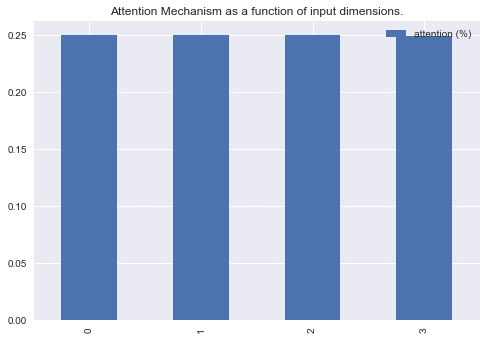

In [90]:
#获得网络权重
#weights = np.array(model.get_weights())
#print(weights)
#输出attention层权重
attention_layer_model = Model(inputs=model.input,outputs=model.get_layer('attention_weight').output)
attention_weight = attention_layer_model.predict(x_train)
attention_weight_final=np.mean(np.array(attention_weight), axis=0)
pd.DataFrame(attention_weight_final, columns=['attention (%)']).plot(kind='bar',
                                                                         title='Attention Mechanism as '
                                                                               'a function of input'
                                                                               ' dimensions.')
plt.show()

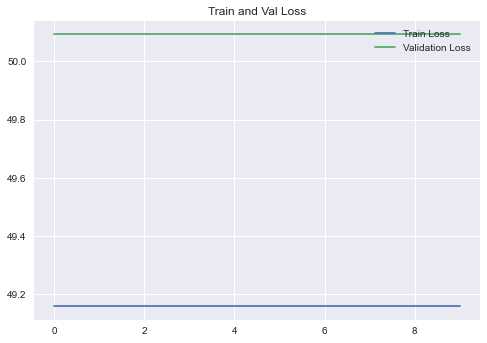

In [91]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

Text(0.5, 1.0, 'Train Data')

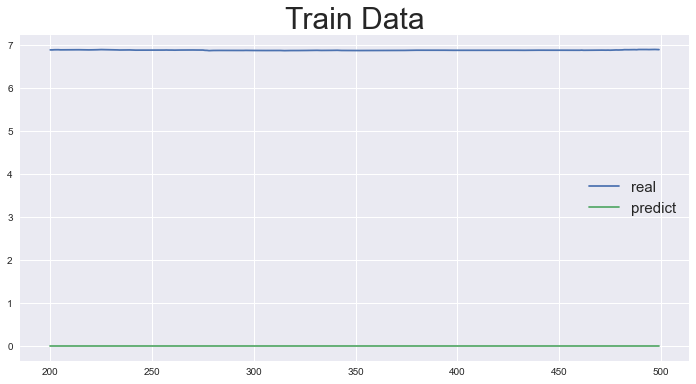

In [92]:
#在训练集上的拟合结果
y_train_predict=model.predict(x_train)*scale
y_train_predict=y_train_predict[:,0]
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题

Text(0.5, 1.0, 'Test Data')

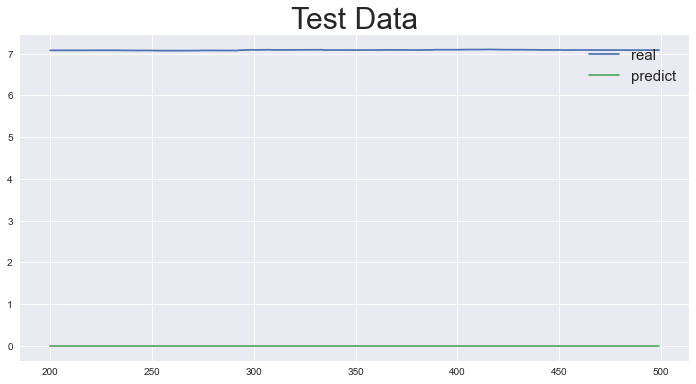

In [93]:
#在测试集上的预测
y_test_predict=model.predict(x_test)*scale
y_test_predict=y_test_predict[:,0]
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
draw.iloc[200:500,0].plot(figsize=(12,6))
draw.iloc[200:500,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data",fontsize='30') #添加标题